In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns

In [56]:
df = pd.read_csv('legacy_cost_computation/table-cost-popup.csv')
df = df[df.columns[1:]]

In [57]:
def hosp_type(duree):
    if duree == 0:
        return 'Hopital de jour'
    else:
        return "Sejour de plus d'une journée"

In [58]:
def generate_placement_reason(cmu,motif):
    if cmu==1:
        return 'CMU'
    elif motif == 1:
        return 'AME'
    elif motif == 4:
        return 'SUV'
    else:
        return 'Autre'

In [59]:
if 0:
    print('ok')

In [60]:
def generate_severiy(ghm2):
    try:
        if int(ghm2[-1]):
            return ghm2[-1]
    except:
        return 'Pas de niveau de sévérité'

In [61]:
def generate_ghm_root(ghm2):
    return ghm2[:-1]

In [62]:
df['raison'] = df[['cmu','motif']].apply(lambda x: generate_placement_reason(x.cmu,x.motif),axis=1)

In [63]:
df['hp_type'] = df['duree'].apply(hosp_type)

In [64]:
df['severity'] = df['ghm2'].apply(generate_severiy)

In [65]:
df['ghm_racine'] = df['ghm2'].apply(generate_ghm_root)

In [66]:
df.head()

,finess,mois,annee,sexe,ghm2,GHS,age,duree,supp_rea,supp_si,...,nbActe,nbRum,cmu,motif,dp,cost,raison,hp_type,severity,ghm_racine
0,10007987,12,2011,1,20Z041,7267,44,8,0,0,...,0,1,1.0,NaN,Z502,2977.721930,CMU,Sejour de plus d'une journée,1,20Z04
1,10007987,8,2011,1,20Z041,7267,38,7,0,0,...,0,1,1.0,NaN,Z502,2671.513527,CMU,Sejour de plus d'une journée,1,20Z04
2,10007987,12,2011,1,20Z041,7267,42,6,0,0,...,0,1,1.0,NaN,Z502,2365.305124,CMU,Sejour de plus d'une journée,1,20Z04
3,10007987,9,2011,2,20Z041,7267,27,7,0,0,...,0,1,1.0,NaN,Z502,2671.513527,CMU,Sejour de plus d'une journée,1,20Z04
4,10007987,8,2011,1,20Z041,7267,43,6,0,0,...,0,1,1.0,NaN,Z502,2365.305124,CMU,Sejour de plus d'une journée,1,20Z04


In [68]:
df = df[df['raison']!='Autre']

In [152]:
df['anonyme'].nunique()

3423605

3423605 de patients uniques

# Univariate Analysis - Patients

### Geo Repartition

In [71]:
def finess_departement_extractor(fin_id):
    fin_id = str(fin_id)
    if fin_id[:2] == '98':
        return '976' #mayotte
    elif fin_id[:2] == '97':
        return fin_id[:2] +  fin_id[3]
    else: 
        return fin_id[:2]  

#### CMU

![title](evo_repart_geo_CMU_patient.png)

#### SUV

![SUV](evo_repart_geo_SUV_patient.png)

#### AME

![title](evo_repart_geo_AME_patient.png)

## Groupes Homogènes de Malades (GHM) 

In [88]:
def rename_unnamed(df, label=''):
    for i, cols in enumerate(df.columns.levels):
        cols = cols.tolist()
        for k, col in enumerate(cols):
            if 'Unnamed' in col:
                cols[k] = ' '*k
        df.columns.set_levels(cols,level=i,inplace=True)

In [89]:
enc_mco = pd.read_excel("analysis_ressources/ENC_MCO/ENC_MCO_2018.xlsx",
                       header=[0,1],
                       index_col=[0,1])
enc_mco.columns = enc_mco.columns.droplevel()

In [90]:
enc_mco_racine = enc_mco[enc_mco['GHM V2020'] == 'TOTAL']
enc_mco_racine = enc_mco_racine[['racine','Libellé GHM']]
enc_mco_racine.columns = ['racine','Libellé GHM Racine']

In [92]:
df = pd.merge(df,enc_mco[['GHM V2020','Libellé GHM']],how='inner',left_on='ghm2',right_on='GHM V2020')

In [93]:
df = pd.merge(df,enc_mco_racine,how='inner',left_on='ghm_racine',right_on='racine')

In [95]:
#df = df[['finess','mois','annee','sexe','ghm2','age','duree','supp_rea','motif','dp','cost','raison','hp_type',
#   'severity','Libellé GHM','Libellé GHM Racine', 'ano_date', 'anonyme', 'nbActe', 'nbRum','departement', 'GHM V2020']]

![title](classement_ghm_par_nombre_patients.png)

### Analyse sur tous les séjours ( toute années confondues)

#### Top 10 global GHM selon la procédure associée au séjour

In [32]:
df_raison_ghm = df.groupby(['raison','ghm2']).agg({'ghm2':'count'})
df_raison_ghm.columns = ['GHM ( % sur la procédure)']
df_raison_ghm = df_raison_ghm.groupby(level=0).apply(lambda x: x/x.sum() * 100)
df_raison_ghm = df_raison_ghm.reset_index()

In [33]:
df_raison_ghm = pd.merge(df_raison_ghm,enc_mco[['GHM V2020','Libellé GHM']],how='left',left_on='ghm2',right_on='GHM V2020')

In [34]:
top_10_ghm = list(df['ghm2'].value_counts().index[:10])

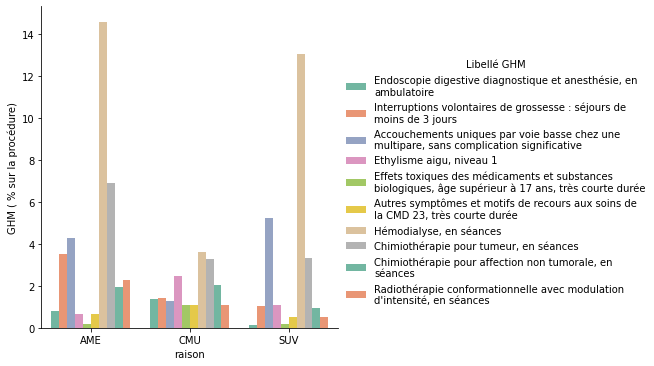

In [37]:
sns.catplot(data=df_raison_ghm[df_raison_ghm['ghm2'].isin(top_10_ghm)],
           kind='bar',
           x='raison',
           y="GHM ( % sur la procédure)",
           hue='Libellé GHM',
           palette='Set2'
           )

### Top 10 GHM selon procédure

In [318]:
top_10_ghm_suv = list(df[df['raison']=='SUV']['ghm2'].value_counts().index[:10])
top_10_ghm_ame = list(df[df['raison']=='AME']['ghm2'].value_counts().index[:10])
top_10_ghm_cmu = list(df[df['raison']=='CMU']['ghm2'].value_counts().index[:10])
top_10_ghm_autre = list(df[df['raison']=='Autre']['ghm2'].value_counts().index[:10])

In [336]:
def plot_top_ghm(df,raison,top_data):
    sns.catplot(data=df[(df['ghm2'].isin(top_data)) & (df['raison']==raison)],
           kind='bar',
           x='raison',
           y="GHM ( % sur la procédure)",
           hue='Libellé GHM',
           palette='Paired'
           )
    

##### SUV

![title](repart_ghm_patients_suv.png)

##### AME

![title](repart_ghm_patients_ame.png)

##### CMU

![title](repart_ghm_patients_cmu.png)

### Analyse temporelle

In [135]:
df_p =  df.groupby(['raison','ghm2']).agg({'anonyme':'nunique'})
df_p = df_p.reset_index()
df_p = pd.merge(df_p,enc_mco[['GHM V2020','Libellé GHM']],how='left',left_on='ghm2',right_on='GHM V2020')

In [136]:
df_patient =  df.groupby(['annee','raison','ghm2']).agg({'anonyme':'nunique'})
df_patient = df_patient.reset_index()
df_patient = pd.merge(df_patient,enc_mco[['GHM V2020','Libellé GHM']],how='left',left_on='ghm2',right_on='GHM V2020')

In [143]:
df_p[df_p['raison']=='SUV'].sort_values(by='anonyme',ascending=False)[:10]['Libellé GHM']

6546    Accouchements uniques par voie basse chez une\...
6541    Accouchements uniques par voie basse chez une\...
6512    Césariennes pour grossesse unique, sans\ncompl...
6523    Affections de l'ante partum sans intervention\...
6105    Autres interventions sur la peau, les tissus\n...
6547    Accouchements uniques par voie basse chez une\...
6532    Interruptions volontaires de grossesse : séjou...
6553    Faux travail et menaces d'accouchements prémat...
6807                             Ethylisme aigu, niveau 1
6956               Chimiothérapie pour tumeur, en séances
Name: Libellé GHM, dtype: object

In [146]:
top_10_ghm_ame = list(df_p[df_p['raison']=='AME'].sort_values(by='anonyme',ascending=False)[:10]['Libellé GHM'])
top_10_ghm_cmu = list(df_p[df_p['raison']=='CMU'].sort_values(by='anonyme',ascending=False)[:10]['Libellé GHM'])
top_10_ghm_suv = list(df_p[df_p['raison']=='SUV'].sort_values(by='anonyme',ascending=False)[:10]['Libellé GHM'])

### Top 10 GHM  par nombre de patients selon procédure

In [112]:
def plot_top_ghm(df,raison,top_data):
    return sns.catplot(data=df[(df['ghm2'].isin(top_data)) & (df['raison']==raison)],
           kind='bar',
           x='raison',
           y="GHM ( % sur la procédure)",
           hue='Libellé GHM',
           palette='Paired'
           )
    

##### SUV

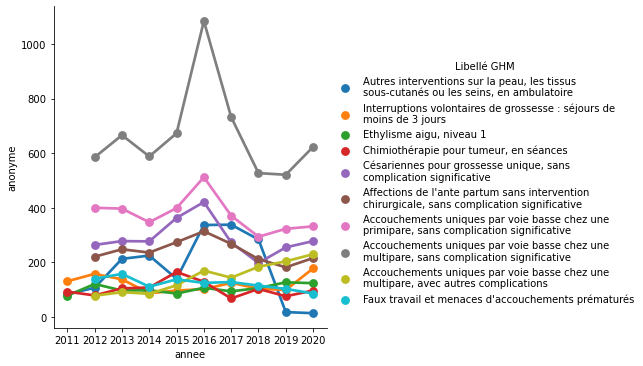

In [148]:
g= sns.catplot(data=df_patient[(df_patient['Libellé GHM'].isin(top_10_ghm_suv)) & (df_patient['raison'] == 'SUV')],
           kind='point',
           x='annee',
           y="anonyme",
           hue='Libellé GHM',
           palette='tab10',      
           )


##### AME

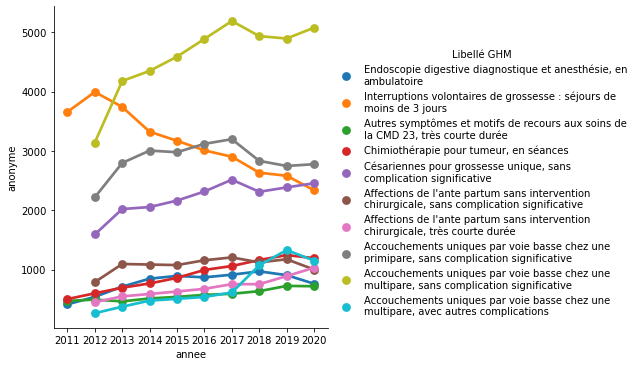

In [149]:
g= sns.catplot(data=df_patient[(df_patient['Libellé GHM'].isin(top_10_ghm_ame)) & (df_patient['raison'] == 'AME')],
           kind='point',
           x='annee',
           y="anonyme",
           hue='Libellé GHM',
           palette='tab10',      
           )

##### CMU

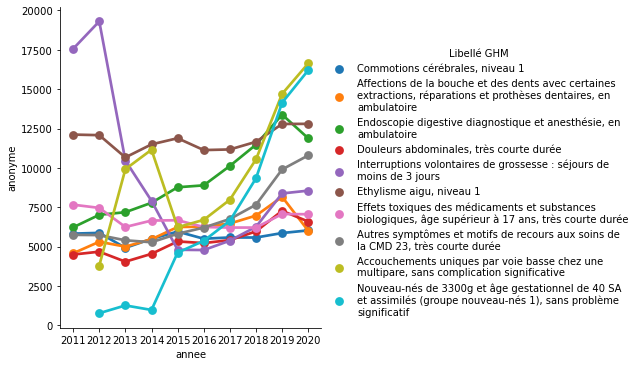

In [150]:
g= sns.catplot(data=df_patient[(df_patient['Libellé GHM'].isin(top_10_ghm_cmu)) & (df_patient['raison'] == 'CMU')],
           kind='point',
           x='annee',
           y="anonyme",
           hue='Libellé GHM',
           palette='tab10',      
           )
    

### Cout

![title](evo_cm_nombre_patients_dispositif.png)

![title](cost_cm_ghm_patient.png)

![title](cost_cm_ghm_patient_cmu.png)

![title](cost_cm_ghm_patient_ame.png)

![title](cost_cm_ghm_patient_suv.png)

### Nombre de séjours des patients

![title](evo_nombre_sejour_dispositf.png)

### Sévérité

![title](repart_severite_dispositif.png)

![title](repart_severite_dispositif_sup.png)

### Type d'hospitalisation

![title](repart_type_hp_dispositif.png)